<a href="https://colab.research.google.com/github/AnastasiaSperanskaya/OptimizationMethodsITMO/blob/master/lab3/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable

##CRS хранение матрицы

>$A_{m,n} =
 \begin{pmatrix}
  1 & 2 & 0 & 4\\
  5 & 0 & 7 & 0\\
  0 & 0 & 9 & 11\\
  1 & 0 & 3 & 4
 \end{pmatrix}$

>data = [ 1, 2, 4, 5, 7, 9, 11, 1, 3, 4 ]

>indicies = [ 0, 1, 3, 0, 2, 2, 3, 0, 2, 3 ]

>indptr = [ 1, 3, 5, 7, 10 ]

In [ ]:
def toCRS(matrix):
  data = np.array([])
  indicies = np.int_([])
  indptr = np.array([1])
  for i in range(len(matrix)):
      for j in range(len(matrix[0])):
        if matrix[i][j] != 0:
          data = np.append(data, matrix[i][j])
          indicies = np.append(indicies, j)
      indptr = np.append(indptr, data.shape[0])
  return data, indicies, indptr

def fromCRS(data, indicies, indptr):
  n = indptr.shape[0] - 1
  matrix = np.zeros((n, n))
  indptr[0] = 0
  j = 0
  for i in  range(n):
    for k in range(indptr[i+1] - indptr[i]):
      matrix[i, indicies[j]] = data[j]
      j += 1
  indptr[0] = 1
  return matrix

In [ ]:
def getElementFromCSR(data, indicies, indptr, x, y):
  n = indptr.shape[0] - 1
  indptr[0] = 0
  j = 0
  result = 0
  for i in  range(n):
    for k in range(indptr[i+1] - indptr[i]):
      if i == x-1 and indicies[j] == y-1:
        result = data[j]
      j += 1
  indptr[0] = 1
  return result

def setElementFromCSR(data, indicies, indptr, x, y, value):
  n = indptr.shape[0] - 1
  indptr[0] = 0

  j = 0
  for i in  range(n):
    for k in range(indptr[i+1] - indptr[i]):
      if i == x-1 and indicies[j] == y-1:
        data[j] = value
        return data, indicies, indptr
      j += 1

  if value != 0:
    for i in range(x, indptr.size):
      indptr[i] = indptr[i]+1
    indicies = np.insert(indicies, indptr[x]-2, y-1)
    data = np.insert(data, indptr[x]-2, value)
  else:
    for i in range(x, indptr.size):
      indptr[i] = indptr[i]-1
    indicies = np.delete(indicies, indptr[x]-1)
    data = np.delete(data, indptr[x]-1)

  indptr[0] = 1
  return data, indicies, indptr

In [ ]:
matrix = np.array([[1,2,3],[4,0,6],[0,8,9]])
print('Original matrix: \n', matrix, '\n')

data, indicies, indptr = toCRS(matrix)
print('Converting matrix to CRS: \ndata:', data, '\nindicies:', indicies, '\nindptr:', indptr, '\n')

print('Converting CRS-matrix to original: \n', fromCRS(data, indicies, indptr))

Original matrix: 
 [[1 2 3]
 [4 0 6]
 [0 8 9]] 

Converting matrix to CRS: 
data: [1. 2. 3. 4. 6. 8. 9.] 
indicies: [0 1 2 0 2 1 2] 
indptr: [1 3 5 7] 

Converting CRS-matrix to original: 
 [[1. 2. 3.]
 [4. 0. 6.]
 [0. 8. 9.]]


In [ ]:
getElementFromCSR(data, indicies, indptr, 2, 2)

0

In [ ]:
data, indicies, indptr = setElementFromCSR(data, indicies, indptr, 3, 1, 4)
print('Converting CRS-matrix to original: \n', fromCRS(data, indicies, indptr))

Converting CRS-matrix to original: 
 [[1. 2. 3.]
 [4. 0. 6.]
 [4. 8. 9.]]


In [ ]:
data, indicies, indptr = setElementFromCSR(data, indicies, indptr, 3, 3, 0)
print('Converting CRS-matrix to original: \n', fromCRS(data, indicies, indptr))

Converting CRS-matrix to original: 
 [[1. 2. 3.]
 [4. 0. 6.]
 [4. 8. 0.]]


In [ ]:
data1 = np.array([])
indicies1 = np.array([])
indptr1 = np.array([])
print('Converting CRS-matrix to original: \n', fromCRS(data1, indicies1, indptr1))

#LU-разложение матрицы

>$A=LU$ 

Распишем матричное уравнение:

>$$\begin{align}
    \begin{bmatrix}
           1 & 0 & \ldots & 0\\
           l_{21} & 1 & \ldots & 0\\
           \vdots & \vdots & \ddots & \vdots\\
           l_{n1} & l_{n2} & \ldots & 1
         \end{bmatrix} & \begin{bmatrix}
           u_{11} & u_{12} & \ldots & u_{1n}\\
           0 & u_{22} & \ldots & u_{2n}\\
           \vdots & \vdots & \ddots & \vdots\\
           0 & 0 & \ldots & u_{nn}
         \end{bmatrix}=\begin{bmatrix}
           a_{11} & a_{12} & \ldots & a_{1n}\\
           a_{21} & a_{22} & \ldots & a_{2n}\\
           \vdots & \vdots & \ddots & \vdots\\
           a_{n1} & a_{n2} & \ldots & a_{nn}
         \end{bmatrix}
\end{align}$$

Перемножим матрицы:

>$$\begin{align}
    \begin{bmatrix}
           a_{11} = u_{11} & a_{12} = u_{12} & a_{13} = u_{13} & \ldots & a_{1n} = u_{1n}\\
           a_{21} = l_{21}u_{11} & a_{22} = l_{21}u_{12}+u_{22} & a_{23} = l_{21}u_{13}+u_{23} & \ldots & a_{2n} = l_{21}u_{1n}+u_{2n}\\
           a_{31} = l_{31}u_{11} & a_{32} = l_{31}u_{12}+l_{32}u_{22} & a_{33} = l_{31}u_{13}+l_{32}u_{23}+u_{33} & \ldots & a_{3n} = l_{31}u_{1n}+l_{32}u_{2n}+u_{3n}\\
           \vdots & \vdots & \vdots & \ddots & \vdots\\
           a_{n1} = l_{n1}u_{11} & a_{n2} = l_{n1}u_{12}+l_{n2}u_{22} & a_{n3} = l_{n1}u_{13}+l_{n2}u_{23}+l_{n3}u_{33} & \ldots & a_{nn} =l_{n1}u_{1n}+l_{n2}u_{2n}+...+l_{nn}u_{nn}\\
         \end{bmatrix}
\end{align}$$

Представим в виде формул:

>$$u_{1j} = a_{1j} \ , при \ j = 1...n \ (из \ 1й \ строки)$$\
$$l_{i1} = \frac{a_{i1}}{u_{11}} \ , при \ i = 2...n \ (из \ 1го \ столбца)$$\
$$u_{2j} = a_{2j} - l_{21}u_{1j} \ , при \ j = 2...n \ (из \ 2й \ строки)$$\
$$l_{i2} = \frac{a_{i2}-l_{i1}u_{12}}{u_{22}} \ , при \ i = 3...n \ (из \ 2го \ столбца)$$

Обобщив, получаем формулы для вычисления элементов треугольных матриц:

>$$u_{ij} = a_{ij} - \sum_{k=1}^{i-1}l_{ik}u_{kj} \ (i \le j - выше \ главной \  диагонали)$$\
$$l_{ij} = \frac{a_{ij} - \sum_{k=1}^{j-1}l_{ik}u_{kj}}{u_{jj}} \ (i > j - ниже \ главной \  диагонали)$$


In [ ]:
def decomposeToLU(A):
    L = np.matrix(np.zeros([A.shape[0], A.shape[1]]))
    U = np.matrix(np.zeros([A.shape[0], A.shape[1]]))
    n = A.shape[0]

    for i in range(L.shape[0]):
            L[i, i] = 1

    for k in range(n):
        for j in range(k, n):
            U[k, j] = A[k, j] - L[k, :k] * U[:k, j]
        for i in range(k + 1, n):
            if U[k, k] != 0:
              L[i, k] = (A[i, k] - L[i, : k] * U[: k, k]) / U[k, k]
            else:
              return print('Error - division by zero (matrix is not appropriate for LU)')
    return L, U

In [ ]:
L, U = decomposeToLU(matrix)
print('L-matrix:\n', L, '\n\nU-matrix:\n', U)

L-matrix:
 [[ 1.  0.  0.]
 [ 4.  1.  0.]
 [ 0. -1.  1.]] 

U-matrix:
 [[ 1.  2.  3.]
 [ 0. -8. -6.]
 [ 0.  0.  3.]]


#Решение системы с помощью LU-разложения

>$AX=B$

Рассмотрим разложение матрицы $A$ в виде $LU$:

>$LUX=B$

Введем вспомогательный вектор $Y = (y_{1}...y_{n})^T$:

>\begin{cases}
   UX=Y\\
   LY=B
 \end{cases}

 Сначала ищем $Y$ (прямой ход метода Гаусса):

 >$$\begin{align}
    \begin{bmatrix}
           1 & 0 & \ldots & 0\\
           l_{21} & 1 & \ldots & 0\\
           \vdots & \vdots & \ddots & \vdots\\
           l_{n1} & l_{n2} & \ldots & 1
         \end{bmatrix} & \begin{bmatrix}
           y_{1}\\
           y_{2}\\
           \vdots\\
           y_{n}
         \end{bmatrix}=\begin{bmatrix}
           b_{1}\\
           b_{2}\\
           \vdots\\
           b_{n}
         \end{bmatrix}
\end{align}$$

Составим систему уравнений:

 >$$\begin{align}
    \begin{cases}
   y_{1}=b_{1}\\
   l_{21}y_{1}+y_{2}=b_{2}\\
   l_{31}y_{1}+l_{32}y_{2}+y_{3}=b_{3}\\
   ...\\
   l_{n1}y_{1}+l_{n2}y_{2}+...+y_{n}=b_{n}
 \end{cases} & \begin{cases}
   y_{1}=b_{1}\\
   y_{2}=b_{2}-l_{21}y_{1}\\
   y_{3}=b_{3}-l_{31}y_{1}-l_{32}y_{2}\\
   ...\\
   y_{n}=b_{n}-l_{n1}y_{1}-l_{n2}y_{2}-...-l_{nn-1}y_{n-1}
 \end{cases}
\end{align}$$

Обобщив, получим формулу для вычисления каждого значения в уравнении системы $LY=B$:

>$$y_{i} = b_{i}-\sum_{k=1}^{i-1}l_{ik}y_{k}$$

Ищем $X$ (обратный ход метода Гаусса):

 >$$\begin{align}
    \begin{bmatrix}
           u_{11} & u_{12} & \ldots & u_{1n}\\
           0 & u_{22} & \ldots & u_{2n}\\
           \vdots & \vdots & \ddots & \vdots\\
           0 & 0 & \ldots & u_{nn}
         \end{bmatrix} & \begin{bmatrix}
           x_{1}\\
           x_{2}\\
           \vdots\\
           x_{n}
         \end{bmatrix}=\begin{bmatrix}
           y_{1}\\
           y_{2}\\
           \vdots\\
           y_{n}
         \end{bmatrix}
\end{align}$$

Составим систему уравнений:

 >$$\begin{align}
    \begin{cases}
   y_{1}=u_{1n}x_{n}+...+u_{12}x_{2}+u_{11}x_{1}\\
   y_{2}=u_{2n}x_{n}+...+u_{22}x_{2}\\
   ...\\
   y_{n}=u_{nn}x_{n}
 \end{cases} & \begin{cases}
   x_{1}=\frac{y_{1}-u_{1n}x_{n}-...-u_{12}x_{2}}{u_{11}}\\
   ...\\
   x_{n-1}=\frac{y_{n-1}-u_{n-1n}x_{n}}{u_{n-1n-1}}\\
   x_{n}=\frac{y_{n}}{u_{nn}}
 \end{cases}
\end{align}$$

Обобщив, получим формулу для вычисления каждого значения в уравнении системы $UX=Y$:

>$$x_{i} = \frac{y_{i}-\sum_{k=i+1}^{n}u_{ik}x_{k}}{u_{ii}}$$

In [ ]:
def solveLU(A, B):
  L, U = decomposeToLU(A)
  Y = np.zeros(L.shape[0])
  X = np.zeros(U.shape[0])
  n = U.shape[0] - 1

  for i in range(L.shape[0]):
    Y[i] = (B[i] - sum([L[i, j]*Y[j] for j in range(i)]))

  for i in range(U.shape[0]):
    X[n-i] = (Y[n-i] - sum([U[n-i, n-j]*X[n-j] for j in range(i)])) / U[n-i, n-i]

  return X

In [ ]:
a = np.array([[16, 2, 0, -2], [4, 20, 1, 0], [2, 0, 10, 0], [-4, 0, 4, 32]])
b = np.array([-13, 24, 7, 0])
x = solveLU(a, b)
print('The salvation:\n', x)

The salvation:
 [-1.01207572  1.35729439  0.90241514 -0.23931136]


In [ ]:
print('Checkup:\n', a@x, '\n\nInitial result:\n', b)

Checkup:
 [-13.  24.   7.   0.] 

Initial result:
 [-13  24   7   0]


#Нахождение обратной матрицы
##(используя LU-разложение)

Обращение матрицы A эквивалентно решению линейной системы

$AX=I$ 

где $X$ — неизвестная матрица, $I$ — единичная матрица. Решение $X$ этой системы является обратной матрицей $A^{-1}$.

Систему можно решить описанным выше методом LU-разложения.

In [ ]:
def getInvert(A):
  result = []
  I = np.zeros(A.shape)
  for i in range(A.shape[0]):
    I[i, i] = 1
    result.append(solveLU(A, I[i]))
  
  return np.array(result).T

In [ ]:
matrixToInvert = np.array([[1, 2],[3, 4]])
print('Inverted matrix:\n', getInvert(matrixToInvert))

Inverted matrix:
 [[-2.   1. ]
 [ 1.5 -0.5]]


#Исследование влияния числа обусловленности на точность решения (1)


In [ ]:
def generateMatrix(size):
    matrix = np.random.randint(-5, 1, size**2).reshape(-1, size)
    matrix = matrix.astype(float)
    for i in range(size):
      matrix[i, i] = sum(matrix[i]) - matrix[i, i] + 10**(-size)
    return matrix

In [ ]:
def makeReport(startSize, endSize):
    currentSize = []
    conditionNumber = []
    error = []
    table = PrettyTable()

    for k in range(startSize, endSize+1):
      expected = np.array([i+1 for i in range(k)])
      A = generateMatrix(k)
      F = A @ expected                 
      result = solveLU(A, F)
      currentSize.append(k)
      error.append(np.linalg.norm(expected - result))
      conditionNumber.append(np.linalg.cond(A))

    table.add_column("Current Size",currentSize)
    table.add_column("Condition Number", conditionNumber)
    table.add_column("Error", error)

    plt.plot(conditionNumber, error, 'bo')
    plt.xlabel("Conditional number")
    plt.ylabel("Error")
    plt.grid(True)
    plot = plt

    return table, plot

+--------------+--------------------+------------------------+
| Current Size |  Condition Number  |         Error          |
+--------------+--------------------+------------------------+
|      4       | 8.659376397408083  | 6.280369834735101e-16  |
|      5       | 6.643967983090364  | 1.3732700395566711e-15 |
|      6       | 8.637242331133866  | 2.318213734067276e-15  |
|      7       | 7.332712496629175  | 1.6050308076832566e-15 |
|      8       | 4.851702690755525  | 3.3984432745746066e-15 |
|      9       | 4.714568950406179  | 2.7733362266239673e-15 |
|      10      | 3.6272787374208963 | 2.560743305106871e-15  |
|      11      | 4.377673018234239  | 4.289830510009564e-15  |
|      12      | 4.539918586590688  | 4.690610161234867e-15  |
|      13      | 3.578184356654966  | 7.182207712846219e-15  |
|      14      | 3.5278282583710263 | 5.9910909847502765e-15 |
|      15      | 3.996736364529297  | 3.9968028886505635e-15 |
|      16      | 3.8600914739737417 | 5.773159728050814

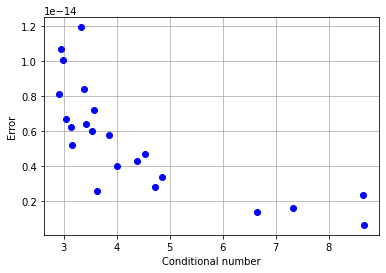

In [ ]:
report, plot = makeReport(4, 25)
print(report)
plot.show()

#Исследование на матрицах Гилберта

In [ ]:
def generateGilbertMatrix(size):
    matrix = np.zeros((size, size))
    for i in range(size):
      for j in range(size):
        matrix[i, j] = 1 / ((i + 1) + (j + 1) - 1)
    return matrix

In [ ]:
def makeGilbertReport(startSize, endSize):
    currentSize = []
    conditionNumber = []
    error = []
    table = PrettyTable()

    for k in range(startSize, endSize+1):
      expected = np.array([i+1 for i in range(k)])
      A = generateGilbertMatrix(k)
      F = A @ expected                 
      result = solveLU(A, F)
      currentSize.append(k)
      error.append(np.linalg.norm(expected - result))
      conditionNumber.append(np.linalg.cond(A))

    table.add_column("Current Size",currentSize)
    table.add_column("Condition Number", conditionNumber)
    table.add_column("Error", error)

    plt.plot(conditionNumber, error, 'bo')
    plt.xlabel("Conditional number")
    plt.ylabel("Error")
    plt.grid(True)
    plot = plt

    return table, plot

+--------------+------------------------+------------------------+
| Current Size |    Condition Number    |         Error          |
+--------------+------------------------+------------------------+
|      3       |   524.0567775860627    | 1.4895204919483639e-15 |
|      4       |   15513.738738929662   | 2.430106513481488e-12  |
|      5       |   476607.2502419595    | 8.790022972690218e-11  |
|      6       |   14951058.641879061   | 2.338622621334871e-09  |
|      7       |   475367356.9028203    | 5.2640614558407474e-08 |
|      8       |   15257575505.048504   | 2.447095518097245e-06  |
|      9       |   493153563504.81415   | 0.00010833458838307278 |
|      10      |   16024905787698.326   |  0.002059742002724448  |
|      11      |   522518134089746.8    |  0.30958616755790797   |
|      12      | 1.643080577584755e+16  |   10.508594327304563   |
|      13      | 5.729989400507761e+18  |   313.2362426013723    |
|      14      |  3.25920065289962e+17  |   154.78320050724204

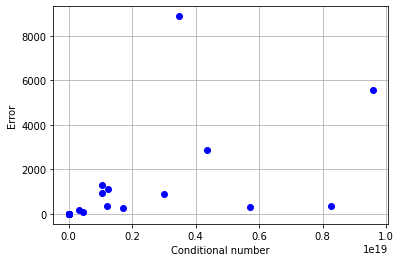

In [ ]:
gilbertReport, gilbertPlot = makeGilbertReport(3, 25)
print(gilbertReport)
gilbertPlot.show()

#Исследование влияния числа обусловленности на точность решения (2)

In [ ]:
def generateMatrix2(size):
    matrix = np.random.randint(-5, 1, size**2).reshape(-1, size)
    matrix = matrix.astype(float)
    for i in range(size):
      matrix[i, i] = sum(matrix[i]) - matrix[i, i]
    return matrix

In [ ]:
def makeReport2(size, k):
    currentDisturb = []
    conditionNumber = []
    error = []
    table = PrettyTable()
    expected = np.array([i+1 for i in range(size)])
    A = generateMatrix2(size)
    F = A @ expected  

    for pow in range(1, k+1):
      #adding disturb to generating matrix
      for i in range(size):
        A[i][i] = A[i][i] - 10**(-pow) + 10**(-(pow-1))

      result = solveLU(A, F)
      currentDisturb.append(10**(-pow))
      error.append(np.linalg.norm(expected - result))
      conditionNumber.append(np.linalg.cond(A))

    table.add_column("Current Disturb",currentDisturb)
    table.add_column("Condition Number", conditionNumber)
    table.add_column("Error", error)

    plt.plot(conditionNumber, error, 'bo')
    plt.xlabel("Conditional number")
    plt.ylabel("Error")
    plt.grid(True)
    plot = plt

    return table, plot

Matrix size: 4
+-----------------+--------------------+--------------------+
| Current Disturb |  Condition Number  |       Error        |
+-----------------+--------------------+--------------------+
|       0.1       | 667.0001405147275  | 88.90197247873819  |
|       0.01      | 164.35169898022338 | 24.052077685145573 |
|      0.001      | 153.1362966973791  | 22.607432527248747 |
|      0.0001     | 152.10160862684137 | 22.474177432953482 |
|      1e-05      | 151.9989408846093  | 22.46095531019852  |
|      1e-06      | 151.98868205882127 | 22.459634123908224 |
|      1e-07      | 151.98765625566605 | 22.459502030598987 |
|      1e-08      | 151.98755367614618 | 22.459488835154204 |
|      1e-09      | 151.98754341819924 | 22.459488477259292 |
|      1e-10      | 151.9875423924076  | 22.45947713282238  |
|      1e-11      | 151.98754228982742 | 22.459513482810173 |
|      1e-12      | 151.9875422795687  | 22.459502425871996 |
|      1e-13      | 151.98754227854565 | 22.45440182051

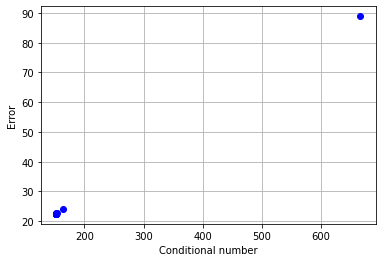

In [ ]:
size = 4
report, plot = makeReport2(size, 15)
print('Matrix size:', size)
print(report)
plot.show()

Matrix size: 6
+-----------------+--------------------+--------------------+
| Current Disturb |  Condition Number  |       Error        |
+-----------------+--------------------+--------------------+
|       0.1       | 7.329752281421082  | 1.001116272450059  |
|       0.01      | 7.497943956444355  | 1.1172613426529396 |
|      0.001      | 7.515174699798572  | 1.1290538902446232 |
|      0.0001     | 7.516901970656371  | 1.1302349422675266 |
|      1e-05      |  7.51707473978911  | 1.130353065459143  |
|      1e-06      | 7.517092017122931  | 1.1303648779582158 |
|      1e-07      | 7.517093744860523  | 1.1303660592099212 |
|      1e-08      | 7.5170939176343285 | 1.1303661773351117 |
|      1e-09      | 7.517093934911707  | 1.1303661891476307 |
|      1e-10      | 7.517093936639442  | 1.1303661903288793 |
|      1e-11      | 7.517093936812222  | 1.130366190447006  |
|      1e-12      | 7.517093936829494  | 1.1303661904588165 |
|      1e-13      | 7.5170939368312215 | 1.130366190459

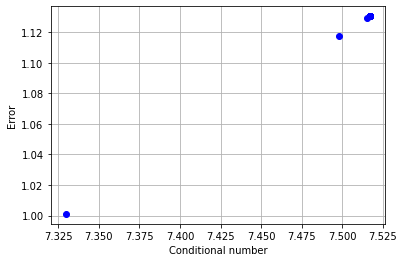

In [ ]:
size = 6
report, plot = makeReport2(size, 15)
print('Matrix size:', size)
print(report)
plot.show()

Matrix size: 8
+-----------------+--------------------+--------------------+
| Current Disturb |  Condition Number  |       Error        |
+-----------------+--------------------+--------------------+
|       0.1       | 4.856192220625942  | 0.6099912051252386 |
|       0.01      | 4.906570678462738  | 0.6754387190382324 |
|      0.001      | 4.911679959520781  | 0.6820321721286763 |
|      0.0001     | 4.9121916121050235 | 0.6826920091007637 |
|      1e-05      | 4.912242784618497  | 0.6827579977192955 |
|      1e-06      | 4.9122479019424095 | 0.6827645966303671 |
|      1e-07      | 4.912248413675523  | 0.6827652565219671 |
|      1e-08      | 4.912248464848845  | 0.6827653225111298 |
|      1e-09      | 4.912248469966175  | 0.6827653291100473 |
|      1e-10      |  4.91224847047791  | 0.6827653297699392 |
|      1e-11      | 4.912248470529085  | 0.6827653298359294 |
|      1e-12      | 4.912248470534201  | 0.6827653298425289 |
|      1e-13      | 4.912248470534713  | 0.682765329843

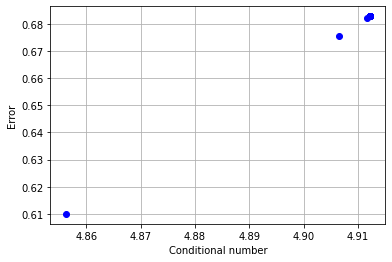

In [ ]:
size = 8
report, plot = makeReport2(size, 15)
print('Matrix size:', size)
print(report)
plot.show()